In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import wandb



In [2]:
batch_size = 64
epochs = 5

wandb.init()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: erik-tegler. Use `wandb login --relogin` to force relogin


In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

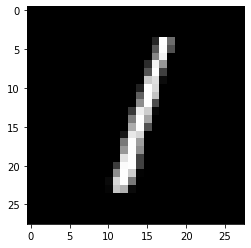

In [4]:
#Demonstrate that we can display data
indx = 2
im = test_data[indx][0]
im = im.squeeze()
plt.imshow(im,cmap="gray")

In [5]:


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2),
        nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack2 = nn.Sequential(
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.linear_relu_stack1(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack2(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            wandb.log({"loss": loss})

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
wandb.watch(model, log_freq=1)
loss_fn = nn.CrossEntropyLoss() # What loss function to use for the output of the network
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) # What method to use for local optimization of the network, currently stochastic gradient descent
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307638  [    0/60000]
loss: 2.300092  [ 6400/60000]
loss: 2.291222  [12800/60000]
loss: 0.987057  [19200/60000]
loss: 0.397507  [25600/60000]
loss: 0.306346  [32000/60000]
loss: 0.255680  [38400/60000]
loss: 0.256674  [44800/60000]
loss: 0.257445  [51200/60000]
loss: 0.229398  [57600/60000]
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.231748 

Epoch 2
-------------------------------
loss: 0.180239  [    0/60000]
loss: 0.128982  [ 6400/60000]
loss: 0.102629  [12800/60000]
loss: 0.281393  [19200/60000]
loss: 0.075211  [25600/60000]
loss: 0.089462  [32000/60000]
loss: 0.090596  [38400/60000]
loss: 0.160517  [44800/60000]
loss: 0.208037  [51200/60000]
loss: 0.121898  [57600/60000]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.124350 

Epoch 3
-------------------------------
loss: 0.056557  [    0/60000]
loss: 0.124348  [ 6400/60000]
loss: 0.071332  [12800/60000]
loss: 0.214767  [19200/60000]
loss: 0.042347  [25600/60000]
loss: 0.049662  [32000/600